In [16]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2_score
from sklearn.metrics import mean_squared_error as mse

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [17]:
plt.rcParams['figure.figsize'] = [18, 10]

## Importing Dataset

In [18]:
df = pd.read_csv("../../Dataset/Gold.csv")
df

,Date,Open,Close,High,Low
0,2018-01-01,1300.760,1313.075,1316.08375,1300.6425
1,2018-01-02,1302.910,1316.500,1318.91000,1302.8550
2,2018-01-03,1318.375,1318.875,1321.30000,1307.7100
3,2018-01-04,1313.105,1327.875,1327.87500,1306.0500
4,2018-01-05,1322.050,1319.590,1323.50500,1313.9100
...,...,...,...,...,...
2339,2024-05-28,2352.200,2361.310,2363.46000,2340.4200
2340,2024-05-29,2361.390,2339.110,2361.79000,2335.0700
2341,2024-05-30,2338.880,2343.380,2351.09000,2323.0300
2342,2024-05-31,2343.340,2327.820,2359.58000,2320.6300


In [19]:
df.dtypes

Date      object
Open     float64
Close    float64
High     float64
Low      float64
dtype: object

In [20]:
df = df[["Close"]]
df.reset_index(drop=True)

,Close
0,1313.075
1,1316.500
2,1318.875
3,1327.875
4,1319.590
...,...
2339,2361.310
2340,2339.110
2341,2343.380
2342,2327.820


In [21]:
df.head()

,Close
0,1313.075
1,1316.500
2,1318.875
3,1327.875
4,1319.590


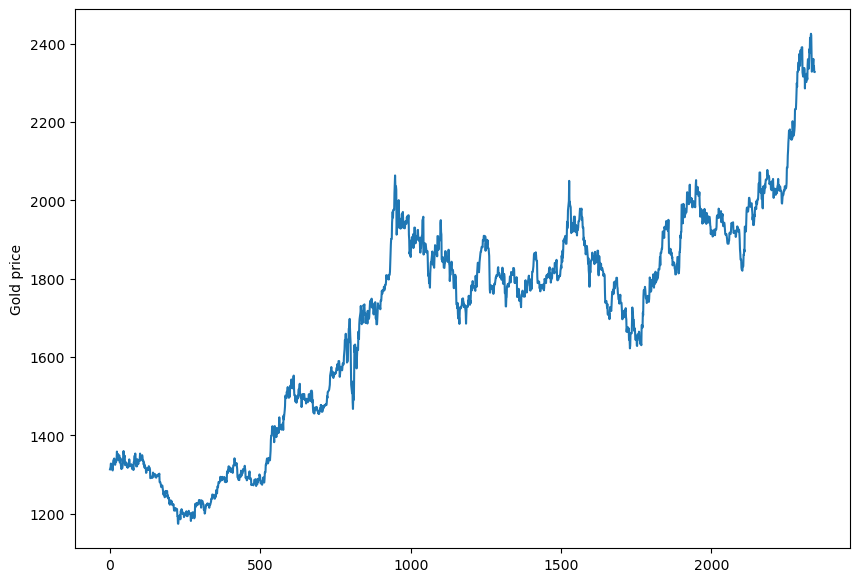

In [22]:
#Đồ thị giá đóng
df.Close.plot(figsize = (10, 7))
plt.ylabel("Gold price")
plt.show()


In [23]:
#train test split
train_size = int(0.7 * len(df))

train_df = df[:train_size]
test_df = df[train_size:]

In [24]:
model = ETSModel(
    train_df['Close'],
    error="mul",
    trend="add",
    seasonal="mul",
    damped_trend=False,
    seasonal_periods=90)

res = model.fit()
print(res.summary())

                                 ETS Results                                  
Dep. Variable:                  Close   No. Observations:                 1640
Model:                       ETS(MAM)   Log Likelihood               -6370.411
Date:                Thu, 13 Jun 2024   AIC                          12932.822
Time:                        12:32:50   BIC                          13451.457
Sample:                             0   HQIC                         13125.170
                               - 1640   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9961      0.024     41.511      0.000       0.949       1.043
smoothing_trend      9.961e-05        nan        nan        nan         nan         nan
smoothing_season

## FORECASTING

In [25]:
predicted = res.predict(start = len(train_df), end = len(train_df) + len(test_df) - 1)

In [26]:
mape = np.mean(np.abs(predicted - test_df['Close'])/np.abs(test_df['Close'])) *100
mse = np.mean(np.square(test_df['Close'] - predicted))
rmse = np.sqrt(mse)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): 5.777519271448788
Mean Squared Error (MSE): 24542.91166071186
Root Mean Squared Error (RMSE): 156.66177472731457


In [27]:
# Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Predict the closing prices for the next 90 days
y_next_90_days = res.predict(start = len(df), end = len(df) + 90 - 1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
2344    1940.231995
2345    1941.421621
2346    1939.380153
2347    1942.777292
2348    1940.455215
           ...     
2429    1959.713612
2430    1960.839045
2431    1964.329647
2432    1965.560419
2433    1966.787609
Length: 90, dtype: float64


In [28]:
predicted

1640    1821.687645
1641    1821.113951
1642    1821.888423
1643    1820.685857
1644    1820.351772
           ...     
2339    1943.036917
2340    1944.154351
2341    1947.616832
2342    1948.838713
2343    1950.057044
Length: 704, dtype: float64

In [29]:
dt_train = np.append(train_df, predicted.iloc[0]) 

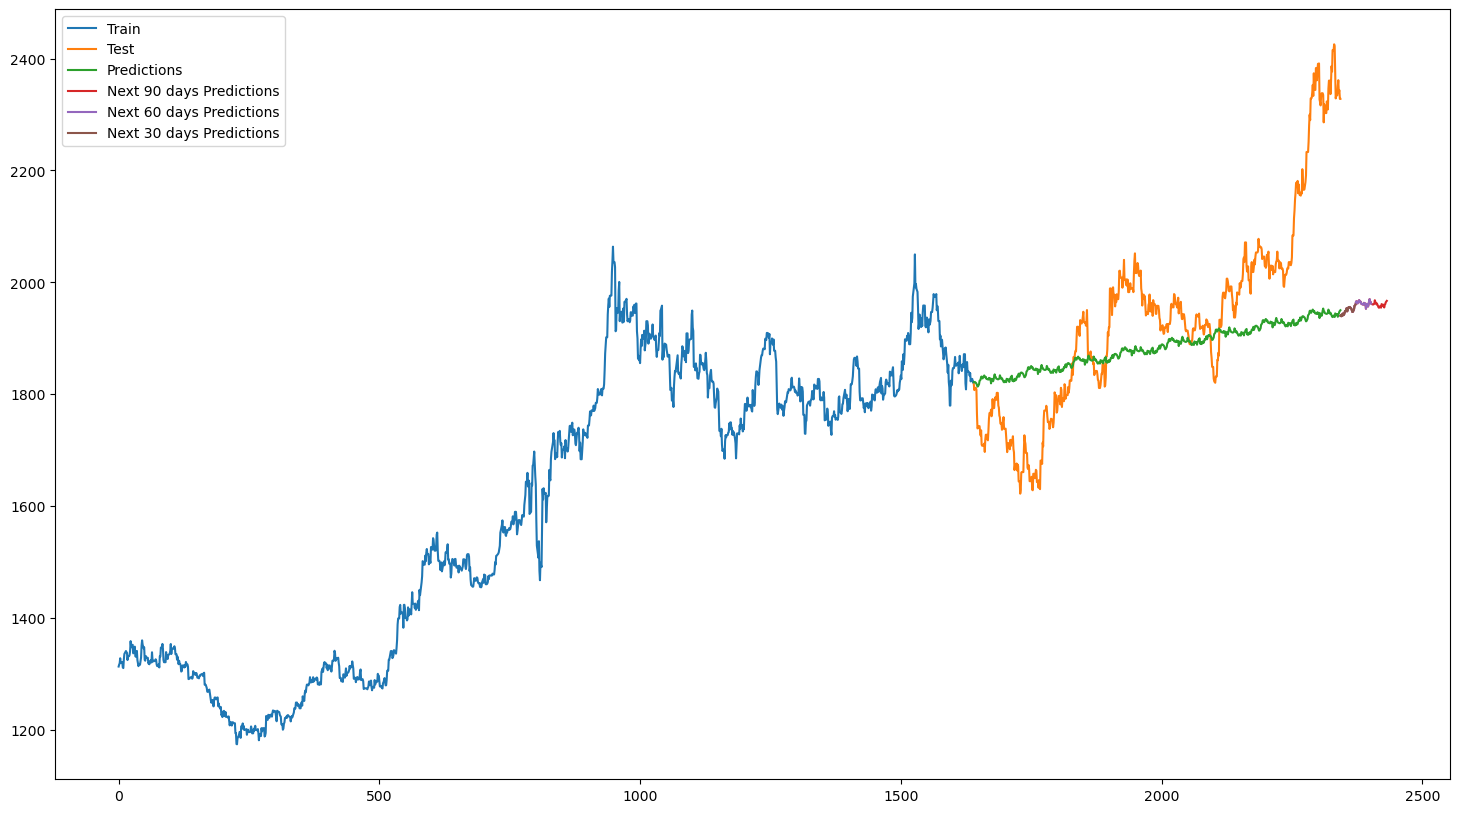

In [30]:
fig, ax = plt.subplots()

plt.plot(pd.RangeIndex(start=0, stop=len(dt_train), step=1), dt_train)
plt.plot(test_df.index, test_df)
plt.plot(test_df.index, predicted)
plt.plot(last_data,y_next_90_days)
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+60, step=1),y_next_90_days[0:60])
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+30, step=1),y_next_90_days[0:30])
plt.legend(['Train', 'Test', 'Predictions', 'Next 90 days Predictions', 'Next 60 days Predictions', 'Next 30 days Predictions'])
plt.show()
